In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

In [2]:
def calc_gamma(l):
    """
    Calcula a aceleração da gravidade no elipsóide de referência (WGS 84) pela equação de Somigliana
    """
    
    a = 6378137.0
    b = 6356752.3142
    ga = 9.7803253359
    gb = 9.8321849378
    
    numerador = a * ga * np.cos(np.pi*l/180)**2 + b*gb*np.sin(np.pi*l/180)**2
    denominador = np.sqrt(a**2 * (np.cos(np.pi*l/180)**2) + b**2*(np.sin(np.pi*l/180)**2))
    
    return numerador/denominador


def plota_gamma(l, gamma):
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(l, gamma)
    ax.set_xlabel('Latitude (º)', fontsize=14)
    ax.set_ylabel('g (m/s$^2$)', fontsize=14)
    ax.set_title('Aceleração da gravidade calculada pela fórmula de Somigliana', fontsize=14)
    ax.set_xlim([-90, 90])
    ax.set_ylim([9.75, 9.85])
    ax.grid()
    plt.show()
    
    
def seleciona_area(data, area):
    
    """
    Seleciona uma área no arquivo de dados a partir das coordenadas fornecidas. Foi feito asism
    para ser mais rápido do que plotar o arquivo todo e só depois selecionar a área.
    """

    if area[2] < 0:
        area[2] = 360 + area[2]
    if area[3] < 0:
        area[3] = 360 + area[3]

    d_lat = np.unique(data[:,1])[1] - np.unique(data[:,1])[0]
    d_lon = data[1, 0] - data[0, 0]
    
    # seleciona latitudes
    lat_ind1 = np.abs(data[:,1]-area[0]).argmin()
    lat_ind2 = np.abs(data[:,1]-area[1] + d_lat).argmin()
    data2 = data[lat_ind1:lat_ind2, :]

    # seleciona longitudes
    lon_inds = np.where((data2[:,0] > area[2]) & (data2[:,0] < (area[3] + d_lon)))
    data3 = data2[lon_inds[0], :]

    # reorganiza as informações
    lon, lat, alt, g = data3[:,0], data3[:,1], data3[:,2], data3[:,3]
    lon2 = lon[:int(np.abs(area[3]-area[2])/d_lon)]
    lat2 = np.reshape(lat, [int(np.abs(area[1]-area[0])/d_lat)+1, int(np.abs(area[3]-area[2])/d_lon)])[:, 1]
    alt2 = np.reshape(alt, [int(np.abs(area[1]-area[0])/d_lat)+1, int(np.abs(area[3]-area[2])/d_lon)])
    g2 = np.reshape(g, [int(np.abs(area[1]-area[0])/d_lat)+1, int(np.abs(area[3]-area[2])/d_lon)])
    
    return lon2, lat2, alt2, g2


def plota_mapa(xx, yy, zz, title=None):

    fig = plt.figure(figsize=(8, 8))
    ax = plt.axes(projection=ccrs.PlateCarree())
    z = plt.contourf(xx, yy, zz, 120, transform=ccrs.PlateCarree(), cmap='hot_r')
    plt.colorbar(z, ax=ax, label='Elevação (m)', shrink=0.5)

    ax.coastlines(resolution='50m')
    ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
    
    if title:
        ax.set_title(title, fontsize=14)

    plt.tight_layout()
    plt.show()

### calcular a aceleração pela formula de Somigliana

In [3]:
dados = np.loadtxt('eigen-6c3stat-0_5-mundo.txt')
lat = np.unique(dados[:,1])
somig = calc_gamma(lat)

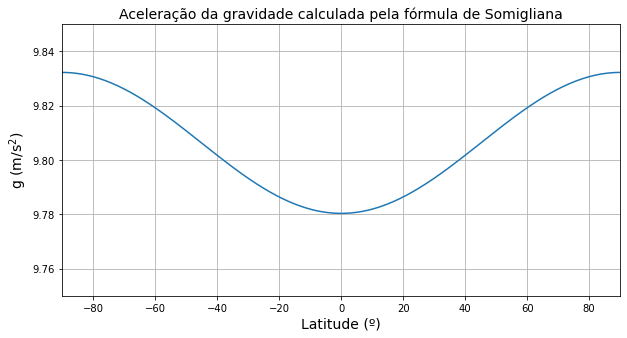

In [4]:
plota_gamma(lat, somig)

**Explique o gráfico acima.** Quais fatores contribuem para este comportamento?

# Mapa de Topografia

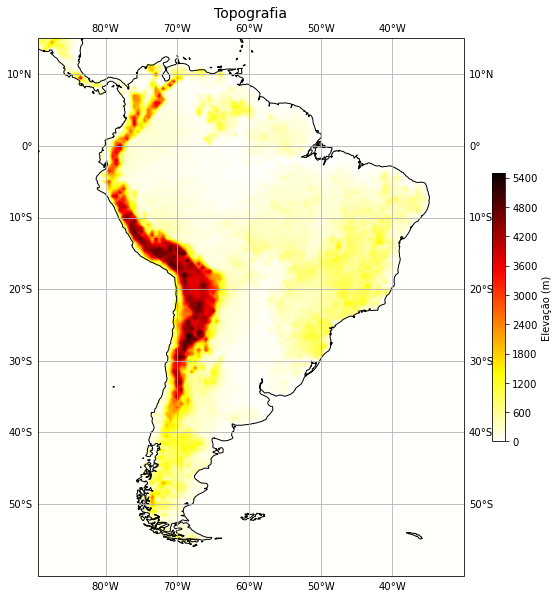

In [5]:
regiao = [15.0, -60.0, -90.0, -30.0]      # [lat_min, lat_max, lon_min, lon_max]    América do Sul
#regiao = [-10.0, -30.0, -80.0, -60.0]    # [lat_min, lat_max, lon_min, lon_max]    América do Sul (zoom nos Andes)
#regiao = [60.0, 10.0, 50.0, 120.0]       # [lat_min, lat_max, lon_min, lon_max]    Himalaia

lon, lat, h, g_medido = seleciona_area(dados, regiao)
plota_mapa(lon, lat, h, title='Topografia')

# Anomalia Ar-livre

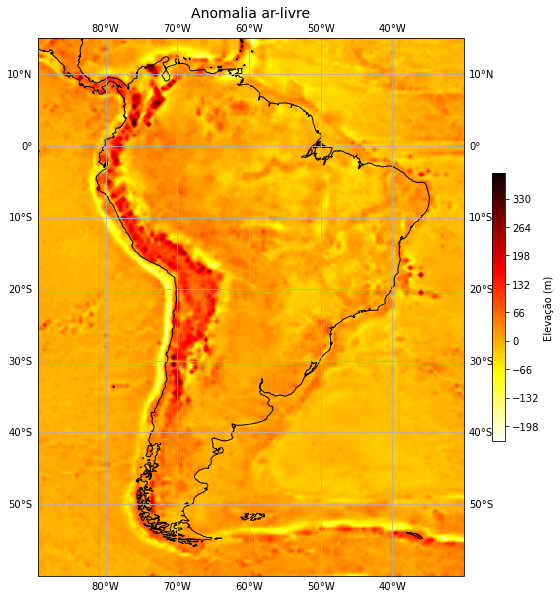

In [8]:
gamma = np.repeat(calc_gamma(lat)*1e5, np.shape(g_medido)[1])
gamma = np.reshape(gamma, np.shape(g_medido))
g_al = g_medido - gamma + 0.3086 * h
plota_mapa(lon, lat, g_al, title='Anomalia ar-livre')

**Faça** uma estimativa do perfil passando pelo paralelo -20º e entre os meridianos -80º e -60º. Explique este comportamento.

# Anomalia Bouger

In [9]:
topog = np.loadtxt('etopo1-0_5-mundo.txt')

In [ ]:
G = 6.67408e-11    # m^3 kg^-1 s^-2
rho = 